## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [0]:
import os
import keras
import itertools

# 神經網絡正規化
from keras.regularizers import l1, l2, l1_l2 
# 神經網絡隨機拋棄、批次標準化、激活函數
from keras.layers import Dropout, BatchNormalization, Activation 


import matplotlib.pyplot as plt
%matplotlib inline


# Disable GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
train, test = keras.datasets.cifar10.load_data( )

170500096/170498071 [==============================] - 4s 0us/step


# 資料前處理 - 標準化 及 獨熱編碼(OneHot Encoding)

In [0]:
def preproc_x( x, flatten = True ) :
    x = x / 255.
    if flatten:
        x = x.reshape( ( len(x), -1 ) )
    return x

def preproc_y( y, num_classes = 10 ) :
    if y.shape[ -1 ] == 1:
        y = keras.utils.to_categorical( y, num_classes )
    return y    

In [0]:
x_train, y_train = train
x_test, y_test = test

# 資料前處理 - X 標準化
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# 資料前處理 - Y 轉成 onehot
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

# 1 建立神經網絡模型
  *  L1- Regularization
  * Optimizers: SGD 
  * Learning Rate = 0.001 
  * Dropout Rate = 0.25, 0.3

In [5]:
def build_mlp( input_shape, output_units = 10, num_neurons = [ 512, 256, 128 ], l1_parameter = 0, dropout_ratio = 0 ) : 
    
    input_layer = keras.layers.Input( input_shape )
    
    for i, n_units in enumerate( num_neurons ) : 
        if i == 0 :
            x = keras.layers.Dense( units = n_units, 
                                    activation = "relu",   # 激活函數
                                    kernel_regularizer = l1( l1_parameter ),
                                    name = "Hidden_Layer_" + str( i+1 ) )( input_layer )  
            
            # Dropout Layer
            x = Dropout( rate = dropout_ratio, 
                         name = "Dropout_Layer_" + str( i+1 ) )( x ) 
              
        else:
            x = keras.layers.Dense( units = n_units, 
                                    activation = "relu", 
                                    kernel_regularizer = l1( l1_parameter ), 
                                    name = "Hidden_Layer_" + str( i+1 ) )( x )  
            
            # Dropout Layer
            x = Dropout( rate = dropout_ratio,
                         name = "Dropout_Layer_" + str( i+1 ) )( x )  
              
              
    output_layer = keras.layers.Dense( units = output_units, 
                                       activation = 'softmax', 
                                       name = 'Output_Layer' )( x )
    
    model = keras.models.Model( inputs = [ input_layer ], outputs = [ output_layer ] )
    return model

model = build_mlp( input_shape = x_train.shape[ 1: ] ) 
model.summary( )

W0721 06:34:06.011171 140346161702784 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0721 06:34:06.048293 140346161702784 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0721 06:34:06.055657 140346161702784 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
Hidden_Layer_1 (Dense)       (None, 512)               1573376   
_________________________________________________________________
Dropout_Layer_1 (Dropout)    (None, 512)               0         
_________________________________________________________________
Hidden_Layer_2 (Dense)       (None, 256)               131328    
_________________________________________________________________
Dropout_Layer_2 (Dropout)    (None, 256)               0         
_________________________________________________________________
Hidden_Layer_3 (Dense)       (None, 128)               32896     
_________________________________________________________________
Dropout_Layer_3 (Dropout)    (None, 128)               0         
__________

## 1.1 設定超參數

In [0]:
EPOCHS = 50
BATCH_SIZE = 512

L1_PARAMETER = 1e-6            # for activation function with regularization
Dropout_Ratio = [ 0.25, 0.3 ]  # Dropuot Layer

LEARNING_RATE = 1e-3  # for optimizer
MOMENTUM = 0.95       # for optimizer

## 1.2 優化器(Optimizer)

In [0]:
SGD = keras.optimizers.SGD( lr = LEARNING_RATE, 
                            momentum = MOMENTUM, 
                            nesterov = True
                            )

Optimizers = 'SGD'

## 1.3 訓練模型

In [8]:
results = {}

"""
建立訓練與實驗迴圈並蒐集資料
"""
for dropout_ratio in Dropout_Ratio :
    keras.backend.clear_session( )    # 清掉舊的 Graph 
    
    print( 'Dropout Ratio = ' + str( dropout_ratio ) )
    model = build_mlp( input_shape = x_train.shape[ 1: ],
                       l1_parameter = L1_PARAMETER, 
                       dropout_ratio = dropout_ratio
                       )
    model.summary( )
    
    
    # 執行神經網絡
    model.compile( loss = 'categorical_crossentropy', 
                   optimizer = Optimizers, 
                   metrics=[ 'accuracy' ] 
                   )

    model.fit( x_train, y_train, 
               epochs = EPOCHS,     
               batch_size = BATCH_SIZE, 
               validation_data = ( x_test, y_test ), 
               shuffle = True
               )
    
    # Collect results
    train_loss = model.history.history[ 'loss' ]
    valid_loss = model.history.history[ 'val_loss' ]
    train_acc = model.history.history[ 'acc' ]
    valid_acc = model.history.history[ 'val_acc' ]
    
    exp_name_tag = "dropout.-%s" % str( dropout_ratio )
    results[ exp_name_tag ] = { 'train-loss': train_loss,
                                'valid-loss': valid_loss,
                                'train-acc': train_acc,
                                'valid-acc': valid_acc
                                }

W0721 06:34:06.181409 140346161702784 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0721 06:34:06.186175 140346161702784 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0721 06:34:06.220477 140346161702784 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Dropout Ratio = 0.25
_________________________________________________________________


W0721 06:34:06.322044 140346161702784 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
Hidden_Layer_1 (Dense)       (None, 512)               1573376   
_________________________________________________________________
Dropout_Layer_1 (Dropout)    (None, 512)               0         
_________________________________________________________________
Hidden_Layer_2 (Dense)       (None, 256)               131328    
_________________________________________________________________
Dropout_Layer_2 (Dropout)    (None, 256)               0         
_________________________________________________________________
Hidden_Layer_3 (Dense)       (None, 128)               32896     
_________________________________________________________________
Dropout_Layer_3 (Dropout)    (None, 128)               0         
_________________________________________________________________
Output_Lay

W0721 06:34:06.630916 140346161702784 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 11s 226us/step - loss: 2.3172 - acc: 0.1452 - val_loss: 2.1972 - val_acc: 0.2283
Epoch 2/50
50000/50000 [==============================] - 10s 205us/step - loss: 2.2070 - acc: 0.2003 - val_loss: 2.1006 - val_acc: 0.2815
Epoch 3/50
50000/50000 [==============================] - 10s 206us/step - loss: 2.1389 - acc: 0.2299 - val_loss: 2.0409 - val_acc: 0.3025
Epoch 4/50
50000/50000 [==============================] - 10s 205us/step - loss: 2.0899 - acc: 0.2485 - val_loss: 1.9901 - val_acc: 0.3213
Epoch 5/50
50000/50000 [==============================] - 10s 206us/step - loss: 2.0485 - acc: 0.2700 - val_loss: 1.9560 - val_acc: 0.3262
Epoch 6/50
50000/50000 [==============================] - 11s 210us/step - loss: 2.0186 - acc: 0.2826 - val_loss: 1.9258 - val_acc: 0.3365
Epoch 7/50
50000/50000 [==============================] - 10s 207us/step - loss: 1.9949 - acc: 0.2938 - val_loss: 1.

## 1.4 損失函數及準確率

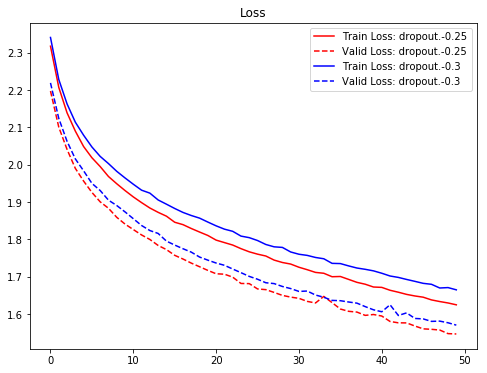

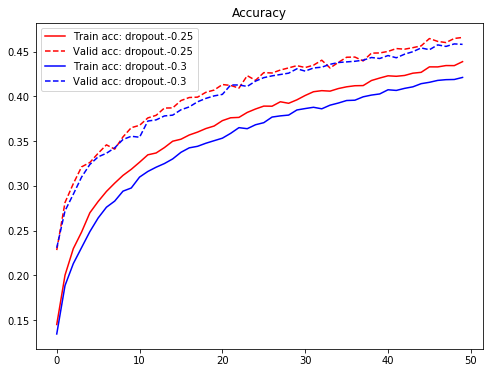

In [9]:
color_bar = [ 'r', 'b' ]

plt.figure( figsize = ( 8, 6 ) )
for i, cond in enumerate( results.keys( ) ) :
    plt.plot( range( len(results[ cond ][ 'train-loss' ] ) ), results[ cond ][ 'train-loss' ], '-', label = 'Train Loss: ' + cond, color = color_bar[i] )
    plt.plot( range( len(results[ cond ][ 'valid-loss' ] ) ), results[ cond ][ 'valid-loss' ], '--', label = 'Valid Loss: ' + cond, color = color_bar[i] )
plt.title( 'Loss' )
plt.legend( )
plt.show( )

plt.figure( figsize = ( 8, 6 ) )
for i, cond in enumerate( results.keys( ) ) :
    plt.plot(range( len( results[ cond ][ 'train-acc' ] ) ), results[ cond ][ 'train-acc' ], '-', label = 'Train acc: ' + cond, color = color_bar[i] )
    plt.plot(range( len( results[ cond ][ 'valid-acc' ] ) ), results[ cond ][ 'valid-acc' ], '--', label = 'Valid acc: ' + cond, color = color_bar[i] )
plt.title( 'Accuracy' )
plt.legend( )
plt.show( )

# 2 建立神經網絡模型
  * Batch Normalization  
  * Optimizers: SGD  
  * Learning Rate = 0.001

In [12]:
def build_mlp( input_shape, output_units = 10, num_neurons = [ 512, 256, 128 ], pre_activate = False ) : 
    
    input_layer = keras.layers.Input( input_shape )
    
    for i, n_units in enumerate( num_neurons ) : 
        if i == 0 :
            x = keras.layers.Dense( units = n_units, 
                                    activation = "relu", 
                                    name = "Hidden_Layer_" + str( i+1 ) )( input_layer )  
            
            if pre_activate :
                x = BatchNormalization( name = "BN_Layer_" + str( i+1 ) )( x )
                x = Activation( 'relu' )( x )
            else :
                x = Activation( 'relu' )( x )
                x = BatchNormalization( name = "BN_Layer_" + str( i+1 ) )( x )
            
            
            
        else :
            x = keras.layers.Dense( units = n_units, 
                                    activation = "relu",  
                                    name = "Hidden_Layer_" + str( i+1 ) )( x )  
            
            if pre_activate :
                # Batch Normalization Layer 在 Activation Function 前加入
                x = BatchNormalization( name = "BN_Layer_" + str( i+1 ) )( x )
                x = Activation( 'relu' )( x )
            else :
                x = Activation( 'relu' )( x )
                x = BatchNormalization( name = "BN_Layer_" + str( i+1 ) )( x )
                          
              
    output_layer = keras.layers.Dense( units = output_units, 
                                       activation = 'softmax', 
                                       name = 'Output_Layer' )( x )
    
    model = keras.models.Model( inputs = [ input_layer ], outputs = [ output_layer ] )
    return model

model = build_mlp( input_shape = x_train.shape[ 1: ] ) 
model.summary( )  

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
Hidden_Layer_1 (Dense)       (None, 512)               1573376   
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
BN_Layer_1 (BatchNormalizati (None, 512)               2048      
_________________________________________________________________
Hidden_Layer_2 (Dense)       (None, 256)               131328    
_________________________________________________________________
activation_2 (Activation)    (None, 256)               0         
_________________________________________________________________
BN_Layer_2 (BatchNormalizati (None, 256)               1024      
__________

## 2.1 設定超參數

In [0]:
EPOCHS = 50
BATCH_SIZE = 512

PRE_ACTIVATE = [ True, False ]  # Batch Normalization Layer before activation function 

LEARNING_RATE = 1e-3     # for optimizer
MOMENTUM = 0.95          # for optimizer 

## 2.2 優化器(Optimizer)

In [0]:
SGD = keras.optimizers.SGD( lr = LEARNING_RATE, 
                            momentum = MOMENTUM, 
                            nesterov = True
                            )

Optimizers = 'SGD'

## 2.3 訓練模型

In [15]:
results = {}

"""
建立訓練與實驗迴圈並蒐集資料
"""
for PRE_ACTIVATE in PRE_ACTIVATE :
    keras.backend.clear_session( )    # 清掉舊的 Graph 
    
    print( 'BN Layer before activative function = ' + str( PRE_ACTIVATE ) )
    model = build_mlp( input_shape = x_train.shape[ 1: ], pre_activate = PRE_ACTIVATE )
    model.summary( )
    
    
    # 執行神經網絡
    model.compile( loss = 'categorical_crossentropy', 
                   optimizer = Optimizers, 
                   metrics=[ 'accuracy' ] 
                   )

    model.fit( x_train, y_train, 
               epochs = EPOCHS,     
               batch_size = BATCH_SIZE, 
               validation_data = ( x_test, y_test ), 
               shuffle = True
               )
    
    # Collect results
    train_loss = model.history.history[ 'loss' ]
    valid_loss = model.history.history[ 'val_loss' ]
    train_acc = model.history.history[ 'acc' ]
    valid_acc = model.history.history[ 'val_acc' ]
    
    exp_name_tag = "BN Layer before activation function .-%s" % str( PRE_ACTIVATE )
    results[ exp_name_tag ] = { 'train-loss': train_loss,
                                'valid-loss': valid_loss,
                                'train-acc': train_acc,
                                'valid-acc': valid_acc
                                }

BN Layer before activative function = True
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
Hidden_Layer_1 (Dense)       (None, 512)               1573376   
_________________________________________________________________
BN_Layer_1 (BatchNormalizati (None, 512)               2048      
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
Hidden_Layer_2 (Dense)       (None, 256)               131328    
_________________________________________________________________
BN_Layer_2 (BatchNormalizati (None, 256)               1024      
_________________________________________________________________
activation_2 (Activation)    (Non

## 2.4 損失函數及準確率

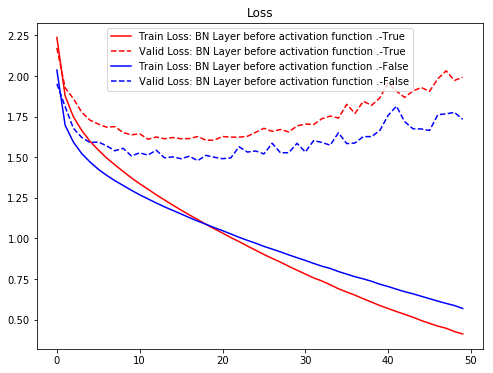

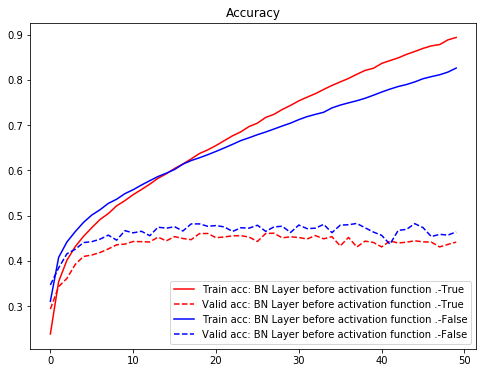

In [16]:
color_bar = [ 'r', 'b' ]

plt.figure( figsize = ( 8, 6 ) )
for i, cond in enumerate( results.keys( ) ) :
    plt.plot( range( len(results[ cond ][ 'train-loss' ] ) ), results[ cond ][ 'train-loss' ], '-', label = 'Train Loss: ' + cond, color = color_bar[i] )
    plt.plot( range( len(results[ cond ][ 'valid-loss' ] ) ), results[ cond ][ 'valid-loss' ], '--', label = 'Valid Loss: ' + cond, color = color_bar[i] )
plt.title( 'Loss' )
plt.legend( )
plt.show( )

plt.figure( figsize = ( 8, 6 ) )
for i, cond in enumerate( results.keys( ) ) :
    plt.plot(range( len( results[ cond ][ 'train-acc' ] ) ), results[ cond ][ 'train-acc' ], '-', label = 'Train acc: ' + cond, color = color_bar[i] )
    plt.plot(range( len( results[ cond ][ 'valid-acc' ] ) ), results[ cond ][ 'valid-acc' ], '--', label = 'Valid acc: ' + cond, color = color_bar[i] )
plt.title( 'Accuracy' )
plt.legend( )
plt.show( )